# Teste supervisionado com dados tunados

In [74]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#selecionando atributos 
from sklearn.feature_selection import RFECV

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 60, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   'class_weight': [{0:.9, 1:.1}, {0:.5, 1:.5}, {0:.7, 1:.3}]}

    #seleciona o melhor modelo de acordo com os parâmetros
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest)
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 5 melhores modelos
    report(grid_search_forest.cv_results_, 5)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, X, y, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))

    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))
    print(f1_score(ytest, ypred))

    #qnt de evadidos 
    print(sum(ytest==0))

    #precisao
    print('Precisao')
    scores = cross_val_score(model, X, y, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))

    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], X.columns[indices[f]],importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    
    
def evaluating_2(model, ytest, ypred, X, y, Xtest):
    #Evaluating
    plt.figure()
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))

    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))
    print(f1_score(ytest, ypred))

    #precisao
    print('Precisao')
    scores = cross_val_score(model, X, y, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    print(dados_clean.info())
    
    return (dados_clean, y)

In [4]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.head(2)

In [14]:
dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

# Modelo 01: utilizando todos os dados

In [15]:
#convertendo os NaN das notas em -1 para usar o RF 
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(8908, 31)
(8908, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 998
Columns: 151 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(136)
memory usage: 2.1 MB
None


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


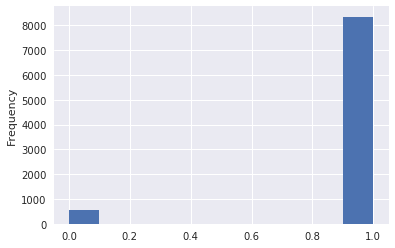

In [16]:
X, y = preparing_data(dados)
y.plot.hist()

In [17]:
#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

In [18]:
#seleciona o melhor modelo
model_forest = make_RF(Xtrain, ytrain)
ypred_forest = model_forest.predict(Xtest)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.961 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.960 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.960 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Mo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


51
11
88
Valor de falso positivo:0.6330935251798561
0.9593533487297922
0.9947318007662835
0.9593533487297922
0.9947318007662835
0.9767223136609453
139
Precisao
[0.9529148  0.96076233 0.95622896 0.96184063 0.96857464 0.95959596
 0.96404494 0.96404494 0.95505618 0.96404494]
0.9607108320854312


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


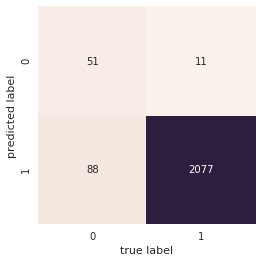

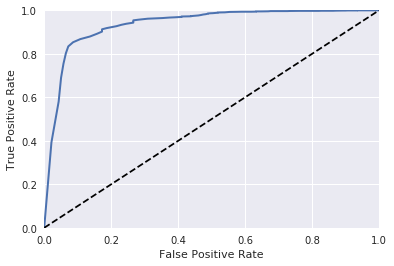

0.9354809256043441
Feature ranking:
1. feature 3 [MatemticaI120H] (0.106351)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.095272)
3. feature 17 [conceito_R] (0.061810)
4. feature 5 [MatemticaI120H_freq] (0.049394)
5. feature 15 [conceito_I] (0.049141)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.038634)
7. feature 9 [idade] (0.026111)
8. feature 20 [conceito_freq_R] (0.022635)
9. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.022336)
10. feature 13 [qtd_pessoas_domicilio] (0.019826)
11. feature 35 [descricao_estado_civil_Solteiro(a)] (0.017878)
12. feature 12 [qnt_salarios] (0.016604)
13. feature 8 [artificial] (0.016593)
14. feature 33 [descricao_estado_civil_Divorciado(a)] (0.015809)
15. feature 14 [tempo_entre_conclusao_ingresso] (0.015301)
16. feature 4 [MatemticaI120H_dependencia] (0.015035)
17. feature 11 [qnt_pc] (0.014262)
18. feature 6 [acompanhamento] (0.011855)
19. feature 25 [descricao_area_residencial_Urbana] (0.010640)
20. feature 23 [descricao_are

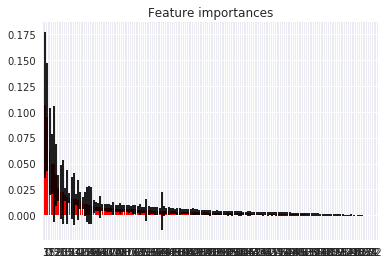

In [27]:
#avaliacao do modelo
evaluating(model_forest, ytest, ypred_forest, X, y, Xtest)

# Modelo 02: sem notas contínuas

In [31]:
dados = dados_tunning.copy()
dados = dados[[       
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'MatemticaI120H_dependencia', 
       'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)

X, y = preparing_data(dados)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(8908, 27)
(8908, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 998
Columns: 147 entries, LnguaPortuguesaeLiteraturaI90H_dependencia to sigla_ZN
dtypes: bool(2), int64(9), uint8(136)
memory usage: 1.9 MB
None


In [32]:
#seleciona o melhor modelo
model_forest = make_RF(Xtrain, ytrain)
ypred_forest = model_forest.predict(Xtest)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.955 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.955 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.954 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}

Mode

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.7266187050359713
0.9536271808999082
0.9947318007662835
0.9536271808999082
0.9947318007662835
0.9737458977965308
139
Precisao
[0.94730942 0.95627803 0.94837262 0.95622896 0.96071829 0.95173962
 0.96516854 0.95505618 0.94831461 0.95280899]
0.9541995242279082


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


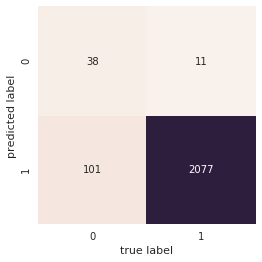

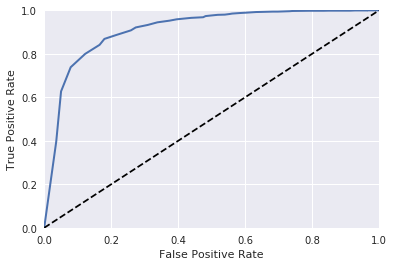

0.9115604068469362
Feature ranking:
1. feature 11 [conceito_I] (0.104026)
2. feature 13 [conceito_R] (0.094299)
3. feature 5 [idade] (0.042247)
4. feature 16 [conceito_freq_R] (0.034736)
5. feature 9 [qtd_pessoas_domicilio] (0.029659)
6. feature 8 [qnt_salarios] (0.022881)
7. feature 10 [tempo_entre_conclusao_ingresso] (0.021355)
8. feature 7 [qnt_pc] (0.021061)
9. feature 15 [conceito_freq_I] (0.020093)
10. feature 19 [descricao_area_residencial_Não informado] (0.019609)
11. feature 1 [MatemticaI120H_dependencia] (0.019136)
12. feature 0 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.018398)
13. feature 29 [descricao_estado_civil_Divorciado(a)] (0.016949)
14. feature 2 [acompanhamento] (0.015213)
15. feature 95 [descricao_raca_Parda] (0.012774)
16. feature 12 [conceito_O] (0.012496)
17. feature 4 [artificial] (0.012067)
18. feature 127 [pessoa_fisica__sexo_M] (0.011862)
19. feature 21 [descricao_area_residencial_Urbana] (0.011105)
20. feature 120 [descricao_trabalho_Nunca trabalhou] 

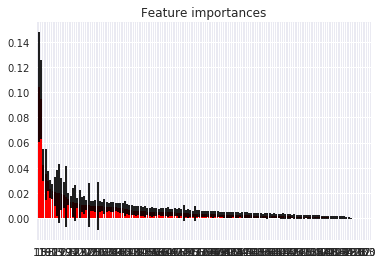

In [33]:
#avaliacao do modelo
evaluating(model_forest, ytest, ypred_forest, X, y, Xtest)

# Modelo 03: sem dados artificiais 

In [43]:
dados = dados_tunning.copy()
dados = dados[dados.artificial == 0]

dados = dados[[       
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 
       'MatemticaI120H',
       'MatemticaI120H_dependencia', 
       'MatemticaI120H_freq',
       'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

X, y = preparing_data(dados)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(7718, 31)
(6124, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6124 entries, 0 to 998
Columns: 149 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(134)
memory usage: 1.4 MB
None


In [44]:
#seleciona o melhor modelo
model_forest = make_RF(Xtrain, ytrain)
ypred_forest = model_forest.predict(Xtest)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.959 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.959 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.958 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}

M

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.6385542168674698
0.9644295302013423
0.9924033149171271
0.9644295302013423
0.9924033149171271
0.9782164737916951
83
Precisao
[0.95439739 0.95765472 0.96078431 0.96405229 0.95915033 0.95915033
 0.96568627 0.96895425 0.95424837 0.96078431]
0.9604862574780183


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


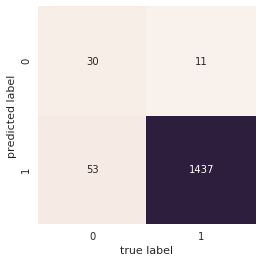

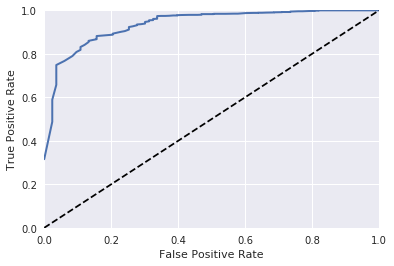

0.9361770285562138
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.135988)
2. feature 3 [MatemticaI120H] (0.109682)
3. feature 17 [conceito_R] (0.063846)
4. feature 5 [MatemticaI120H_freq] (0.055027)
5. feature 15 [conceito_I] (0.048605)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.040380)
7. feature 9 [idade] (0.028614)
8. feature 13 [qtd_pessoas_domicilio] (0.020993)
9. feature 14 [tempo_entre_conclusao_ingresso] (0.017975)
10. feature 12 [qnt_salarios] (0.017286)
11. feature 11 [qnt_pc] (0.016870)
12. feature 19 [conceito_freq_R] (0.014133)
13. feature 4 [MatemticaI120H_dependencia] (0.013855)
14. feature 139 [sigla_MC] (0.013406)
15. feature 6 [acompanhamento] (0.012830)
16. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.012590)
17. feature 130 [sigla_CA] (0.010051)
18. feature 129 [pessoa_fisica__sexo_M] (0.009064)
19. feature 135 [sigla_CNAT] (0.008971)
20. feature 16 [conceito_O] (0.008382)
21. feature 94 [descricao_raca_Branca] (0.007868)
2

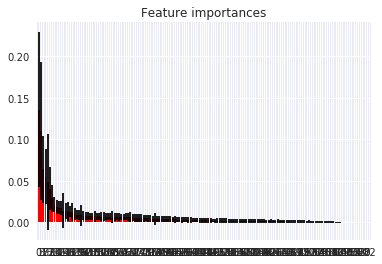

In [45]:
#avaliacao do modelo
evaluating(model_forest, ytest, ypred_forest, X, y, Xtest)

# Modelo 04: removendo atributos com correlação

In [48]:
from sklearn.feature_selection import RFECV

#O X foi definido no Modelo 03

selector = RFECV(model_forest, cv=10, n_jobs=-1)
selector.fit(X, y)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Pais', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros', 'descricao_historico_Técnico em Programação de Jogos Digitais', 'descricao_imovel_Próprio', 'descricao_mae_escolaridade_Ensino fundamental incompleto', 'descricao_mae_escolaridade_Ensino médio completo', 'descricao_pai_escolaridade_Ensino fundamental incompleto', 'descricao_raca_Branca', 'descricao_raca_Parda', 'descricao_responsavel_escolaridade

In [53]:
atributos = ['LnguaPortuguesaeLiteraturaI90H', 
             'LnguaPortuguesaeLiteraturaI90H_dependencia', 
             'LnguaPortuguesaeLiteraturaI90H_freq', 
             'MatemticaI120H', 
             'MatemticaI120H_dependencia', 
             'MatemticaI120H_freq', 
             'acompanhamento', 
             'idade', 
             'possui_necessidade_especial', 
             'qnt_pc', 
             'qnt_salarios', 
             'qtd_pessoas_domicilio', 
             'tempo_entre_conclusao_ingresso', 
             'conceito_I', 
             'conceito_R', 
             'conceito_freq_R', 
             'descricao_area_residencial_Urbana', 
             'descricao_companhia_domiciliar_Mãe', 
             'descricao_companhia_domiciliar_Pais', 
             'descricao_historico_Técnico de Nivel Médio em Informática', 
             'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros', 
             'descricao_historico_Técnico em Programação de Jogos Digitais', 
             'descricao_imovel_Próprio', 
             'descricao_mae_escolaridade_Ensino fundamental incompleto', 
             'descricao_mae_escolaridade_Ensino médio completo', 
             'descricao_pai_escolaridade_Ensino fundamental incompleto',
             'descricao_raca_Branca', 
             'descricao_raca_Parda', 
             'descricao_responsavel_escolaridade_Ensino fundamental incompleto', 
             'descricao_responsavel_escolaridade_Ensino médio completo', 
             'descricao_responsavel_financeiro_Mãe', 
             'descricao_responsavel_financeiro_Pai', 
             'descricao_trabalho_Nunca trabalhou', 
             'pessoa_fisica__sexo_M', 
             'sigla_CA', 
             'sigla_CNAT', 
             'sigla_MC']

print(X.shape)
len(atributos)

(6124, 149)


37

In [75]:
X = X[atributos]
#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

In [76]:
#seleciona o melhor modelo
model_forest = make_RF(Xtrain, ytrain)
ypred_forest = model_forest.predict(Xtest)

{'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight={0: 0.7, 1: 0.3},
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.961 (std: 0.001)
Parameters: {'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 30}

Model with rank: 2
Mean validation score: 0.961 (std: 0.001)
Parameters: {'class_weight': {0: 0.5, 1: 0.5}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.961 

# COLOCAR O GRIDSEARCH EM FAVOR DO FP 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.6385542168674698
0.9644533869885983
0.9930939226519337
0.9644533869885983
0.9930939226519337
0.9785641374617217
83
Precisao
[0.95602606 0.95765472 0.95915033 0.9624183  0.9624183  0.96732026
 0.96568627 0.97222222 0.95261438 0.9624183 ]
0.9617929147772027


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


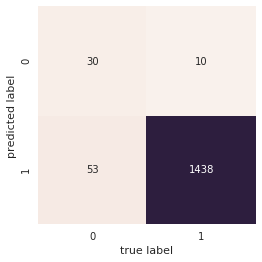

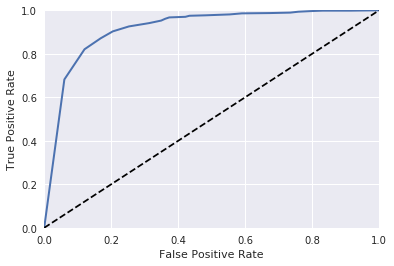

0.9154421553617786
Feature ranking:
1. feature 3 [MatemticaI120H] (0.182743)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.139885)
3. feature 14 [conceito_R] (0.095957)
4. feature 13 [conceito_I] (0.073079)
5. feature 5 [MatemticaI120H_freq] (0.054535)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.045531)
7. feature 7 [idade] (0.030626)
8. feature 9 [qnt_pc] (0.028619)
9. feature 11 [qtd_pessoas_domicilio] (0.023666)
10. feature 12 [tempo_entre_conclusao_ingresso] (0.023635)
11. feature 10 [qnt_salarios] (0.020814)
12. feature 15 [conceito_freq_R] (0.017680)
13. feature 36 [sigla_MC] (0.016949)
14. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.015802)
15. feature 6 [acompanhamento] (0.015144)
16. feature 34 [sigla_CA] (0.014215)
17. feature 4 [MatemticaI120H_dependencia] (0.013197)
18. feature 35 [sigla_CNAT] (0.012452)
19. feature 20 [descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros] (0.011839)
20. feature 8 [possui_necessidade_especial] (0.0115

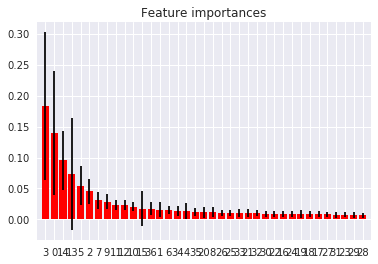

In [77]:
#avaliacao do modelo
evaluating(model_forest, ytest, ypred_forest, X, y, Xtest)

# Modelo 05: comparandos várias ML

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/ana

SGD: 0.942362 (0.011911)
Valor de falso positivo:0.6385542168674698
0.963773069036227
0.9737569060773481
0.963773069036227
0.9737569060773481
0.9687392648574373
Precisao


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_ite

[0.05537459 0.80944625 0.94444444 0.9248366  0.95261438 0.94607843
 0.94444444 0.94934641 0.94281046 0.94934641]
0.8418742415532989


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


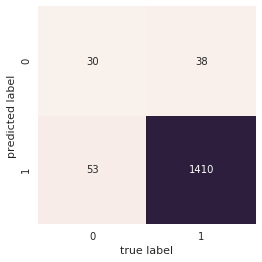

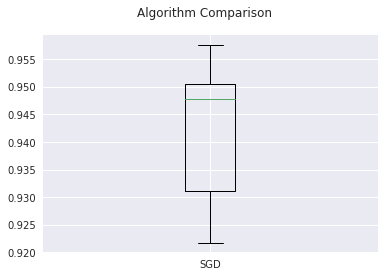

In [73]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.linear_model import SGDClassifier

models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))

models.append(('SGD', SGDClassifier(random_state=42)))
#{1:.9, 2:.5, 3:.01}

#models.append(('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False) ))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    evaluating_2(model, ytest, ypred, X, y, Xtest)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Comparando os modelos

In [ ]:
modelos_fp = [0.6330935251798561, 0.7266187050359713, 0.6385542168674698, 0.6385542168674698]